In [1]:
# Summary of this project (regression)
# --------------------------------- 

# 1) Data collection from yfinance

# 2) Data Preprocessing
#      - format date
#      - remove uncessesary column  

# 3) Corelation Analysis

# 4) Outlier Detection  

# 5) Filtering Data

# 6) Feature Engineering 

# 7) Data Scalling 

# 8) Sequence Generation for LSTM 
#      - Prepare input sequences based on the look-back period  

# 9) Train-Test Split 

# 10) Model Dev

# 11) testing and evaluation 

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import math 
import tensorflow as tf
import pandas_ta as ta
import pandas_datareader as web 
import matplotlib.pyplot as plt 

In [3]:
# Download Apple stock data
# -----------------------------------------------

stock_ticker = yf.Ticker("AAPL")
stock_data = stock_ticker.history(period="max")
# Convert the index to a datetime object
stock_data.index = pd.to_datetime(stock_data.index)

# Format the datetime index to "YYYY-MM-DD"
stock_data.index = stock_data.index.strftime('%Y-%m-%d')

# convert to lowercase comlumn name 
stock_data.columns = [c.lower() for c in stock_data.columns]

# Convert  indexes to datetime just to be sure
stock_data.index = pd.to_datetime(stock_data.index)

del stock_data["dividends"]
del stock_data["stock splits"]
del stock_data["volume"]

In [4]:
stock_data

,open,high,low,close
Date,,,,
1980-12-12,0.098943,0.099373,0.098943,0.098943
1980-12-15,0.094211,0.094211,0.093781,0.093781
1980-12-16,0.087328,0.087328,0.086898,0.086898
1980-12-17,0.089049,0.089479,0.089049,0.089049
1980-12-18,0.091631,0.092061,0.091631,0.091631
...,...,...,...,...
2024-09-24,228.649994,229.350006,225.729996,227.369995
2024-09-25,224.929993,227.289993,224.020004,226.369995
2024-09-26,227.300003,228.500000,225.410004,227.520004


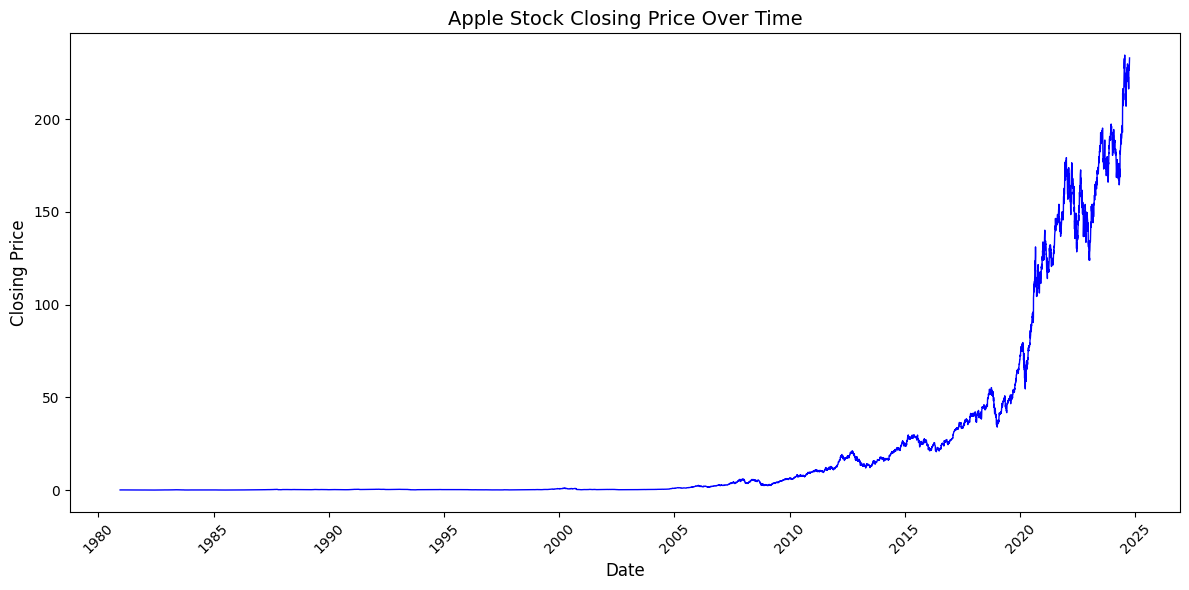

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['close'], linestyle='-', color='b', linewidth=1)
plt.title('Apple Stock Closing Price Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# inspect the data see the correlation between each column 

# Calculate the correlation matrix
correlation_matrix = stock_data.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# To focus specifically on how each column correlates with 'close'
close_correlations = correlation_matrix['close']

# Print the correlations with the 'close' column
print("\nCorrelation with 'close':")
print(close_correlations)

Correlation Matrix:
           open      high       low     close
open   1.000000  0.999944  0.999943  0.999878
high   0.999944  1.000000  0.999926  0.999944
low    0.999943  0.999926  1.000000  0.999943
close  0.999878  0.999944  0.999943  1.000000

Correlation with 'close':
open     0.999878
high     0.999944
low      0.999943
close    1.000000
Name: close, dtype: float64


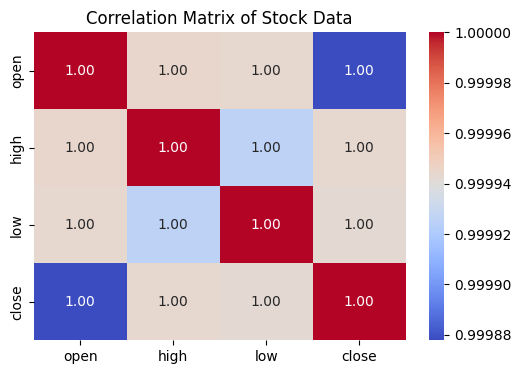

In [7]:
import seaborn as sns

# Plotting the correlation matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Data')
plt.show()

In [8]:
# view outliers 
# --------------------------------------------

from scipy import stats

# Calculate Z-scores
stock_data['z_score'] = stats.zscore(stock_data['close'])

# Define outliers as those with Z-scores > 3 or < -3
outliers = stock_data[(stock_data['z_score'] > 3) | (stock_data['z_score'] < -3)]

# Print number of outliers and the outliers themselves
print(f'Number of outliers: {outliers.shape[0]}')
print(outliers)

Number of outliers: 447
                  open        high         low       close   z_score
Date                                                                
2021-12-07  166.538011  169.000425  165.809131  168.606430  3.102428
2021-12-08  169.542169  173.314590  168.133660  172.447815  3.183872
2021-12-09  172.280382  174.092716  171.305261  171.935638  3.173013
2021-12-10  172.575860  176.929407  172.063674  176.752106  3.275131
2021-12-13  178.396975  179.391800  172.891020  173.097870  3.197654
...                ...         ...         ...         ...       ...
2024-09-24  228.649994  229.350006  225.729996  227.369995  4.348319
2024-09-25  224.929993  227.289993  224.020004  226.369995  4.327118
2024-09-26  227.300003  228.500000  225.410004  227.520004  4.351500
2024-09-27  228.460007  229.520004  227.300003  227.789993  4.357224
2024-09-30  230.039993  233.000000  229.649994  233.000000  4.467685

[447 rows x 5 columns]


In [9]:
# Filter data for dates from 2019 onwards

del stock_data["z_score"]
stock_data_filtered = stock_data[stock_data.index.year >= 2019]

stock_data_filtered

,open,high,low,close
Date,,,,
2019-01-02,37.025776,37.972398,36.868005,37.750084
2019-01-03,34.417789,34.833729,33.944479,33.989899
2019-01-04,34.549256,35.510220,34.374754,35.440895
2019-01-07,35.546081,35.577158,34.876752,35.362015
2019-01-08,35.751657,36.291902,35.503051,36.036121
...,...,...,...,...
2024-09-24,228.649994,229.350006,225.729996,227.369995
2024-09-25,224.929993,227.289993,224.020004,226.369995
2024-09-26,227.300003,228.500000,225.410004,227.520004


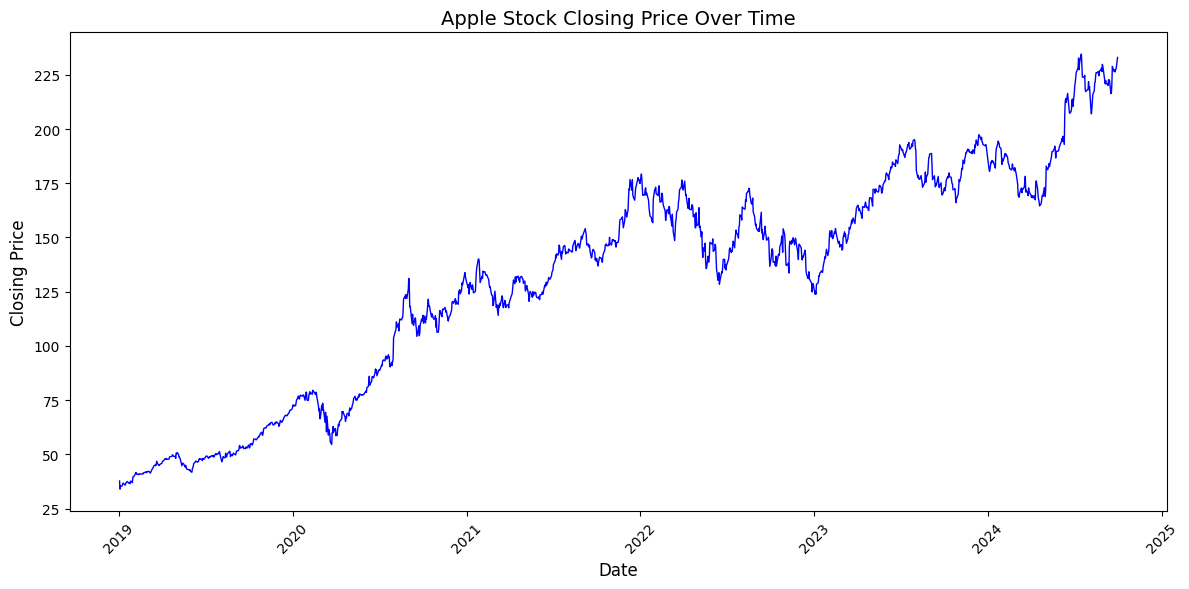

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data_filtered.index, stock_data_filtered['close'], linestyle='-', color='b', linewidth=1)
plt.title('Apple Stock Closing Price Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Calculate Z-scores
stock_data_filtered['z_score'] = stats.zscore(stock_data_filtered['close'])

# Define outliers as those with Z-scores > 3 or < -3
outliers = stock_data_filtered[(stock_data_filtered['z_score'] > 3) | (stock_data_filtered['z_score'] < -3)]

# Print number of outliers and the outliers themselves
print(f'Number of outliers: {outliers.shape[0]}')
print(outliers)

Number of outliers: 0
Empty DataFrame
Columns: [open, high, low, close, z_score]
Index: []


C:\Users\Acer\AppData\Local\Temp\ipykernel_18004\3148896026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered['z_score'] = stats.zscore(stock_data_filtered['close'])


In [12]:
# data from 2019 onwards to avoid extreme outliers 
del stock_data_filtered["z_score"]

stock_data_filtered

,open,high,low,close
Date,,,,
2019-01-02,37.025776,37.972398,36.868005,37.750084
2019-01-03,34.417789,34.833729,33.944479,33.989899
2019-01-04,34.549256,35.510220,34.374754,35.440895
2019-01-07,35.546081,35.577158,34.876752,35.362015
2019-01-08,35.751657,36.291902,35.503051,36.036121
...,...,...,...,...
2024-09-24,228.649994,229.350006,225.729996,227.369995
2024-09-25,224.929993,227.289993,224.020004,226.369995
2024-09-26,227.300003,228.500000,225.410004,227.520004


In [13]:
# Feature Engineering 
# - adding new feature 
# ---------------------------------

# Adding indicators to the stock data

# Example: Calculate 10-day and 50-day SMAs
stock_data_filtered['SMA_10'] = stock_data_filtered['close'].rolling(window=10).mean()
stock_data_filtered['SMA_50'] = stock_data_filtered['close'].rolling(window=50).mean()

# Example: Calculate 10-day and 50-day EMAs
stock_data_filtered['EMA_10'] = stock_data_filtered['close'].ewm(span=10, adjust=False).mean()
stock_data_filtered['EMA_50'] = stock_data_filtered['close'].ewm(span=50, adjust=False).mean()

# Calculate 14-day RSI using pandas_ta
stock_data_filtered['RSI_14'] = ta.rsi(stock_data_filtered['close'], length=14)

stock_data_filtered = stock_data_filtered.dropna()


C:\Users\Acer\AppData\Local\Temp\ipykernel_18004\437301792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered['SMA_10'] = stock_data_filtered['close'].rolling(window=10).mean()
C:\Users\Acer\AppData\Local\Temp\ipykernel_18004\437301792.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered['SMA_50'] = stock_data_filtered['close'].rolling(window=50).mean()
C:\Users\Acer\AppData\Local\Temp\ipykernel_18004\437301792.py:12: SettingWithCopyWarning: 
A value is trying to be s

In [14]:
stock_data_filtered

,open,high,low,close,SMA_10,SMA_50,EMA_10,EMA_50,RSI_14
Date,,,,,,,,,
2019-03-14,44.149019,44.197036,43.827325,44.108208,42.529268,39.632640,42.745322,40.479820,75.107607
2019-03-15,44.377093,44.972467,44.110614,44.681980,42.796947,39.771278,43.097442,40.644611,77.641977
2019-03-18,44.605173,45.226955,44.602769,45.138130,43.089115,39.994243,43.468476,40.820827,79.434616
2019-03-19,45.217334,45.370979,44.633960,44.780403,43.353191,40.181033,43.707008,40.976105,74.396798
2019-03-20,44.708391,45.491025,44.348285,45.171730,43.680648,40.377227,43.973321,41.140639,76.176742
...,...,...,...,...,...,...,...,...,...
2024-09-24,228.649994,229.350006,225.729996,227.369995,223.264000,222.119416,224.487162,220.495661,57.333590
2024-09-25,224.929993,227.289993,224.020004,226.369995,223.634999,221.955845,224.829495,220.726027,55.409150
2024-09-26,227.300003,228.500000,225.410004,227.520004,224.109999,221.933938,225.318679,220.992457,57.188815


In [15]:
# Move 'close' column to the last position
columns = [col for col in stock_data_filtered.columns if col != 'close'] + ['close']
stock_data_filtered = stock_data_filtered[columns]
 
# Print the updated DataFrame
stock_data_filtered

,open,high,low,SMA_10,SMA_50,EMA_10,EMA_50,RSI_14,close
Date,,,,,,,,,
2019-03-14,44.149019,44.197036,43.827325,42.529268,39.632640,42.745322,40.479820,75.107607,44.108208
2019-03-15,44.377093,44.972467,44.110614,42.796947,39.771278,43.097442,40.644611,77.641977,44.681980
2019-03-18,44.605173,45.226955,44.602769,43.089115,39.994243,43.468476,40.820827,79.434616,45.138130
2019-03-19,45.217334,45.370979,44.633960,43.353191,40.181033,43.707008,40.976105,74.396798,44.780403
2019-03-20,44.708391,45.491025,44.348285,43.680648,40.377227,43.973321,41.140639,76.176742,45.171730
...,...,...,...,...,...,...,...,...,...
2024-09-24,228.649994,229.350006,225.729996,223.264000,222.119416,224.487162,220.495661,57.333590,227.369995
2024-09-25,224.929993,227.289993,224.020004,223.634999,221.955845,224.829495,220.726027,55.409150,226.369995
2024-09-26,227.300003,228.500000,225.410004,224.109999,221.933938,225.318679,220.992457,57.188815,227.520004


In [16]:
# objective now to predict price up or down
# add new comlumn tommorow based on closing price 
stock_data_filtered["tomorrow"] = stock_data_filtered["close"].shift(-1)

# convet to 1 or 0 
stock_data_filtered["target"] = (stock_data_filtered["tomorrow"] > stock_data_filtered["close"]).astype(int)

stock_data_filtered

C:\Users\Acer\AppData\Local\Temp\ipykernel_18004\4277977534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered["tomorrow"] = stock_data_filtered["close"].shift(-1)
C:\Users\Acer\AppData\Local\Temp\ipykernel_18004\4277977534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered["target"] = (stock_data_filtered["tomorrow"] > stock_data_filtered["close"]).astype(int)


,open,high,low,SMA_10,SMA_50,EMA_10,EMA_50,RSI_14,close,tomorrow,target
Date,,,,,,,,,,,
2019-03-14,44.149019,44.197036,43.827325,42.529268,39.632640,42.745322,40.479820,75.107607,44.108208,44.681980,1
2019-03-15,44.377093,44.972467,44.110614,42.796947,39.771278,43.097442,40.644611,77.641977,44.681980,45.138130,1
2019-03-18,44.605173,45.226955,44.602769,43.089115,39.994243,43.468476,40.820827,79.434616,45.138130,44.780403,0
2019-03-19,45.217334,45.370979,44.633960,43.353191,40.181033,43.707008,40.976105,74.396798,44.780403,45.171730,1
2019-03-20,44.708391,45.491025,44.348285,43.680648,40.377227,43.973321,41.140639,76.176742,45.171730,46.835423,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,228.649994,229.350006,225.729996,223.264000,222.119416,224.487162,220.495661,57.333590,227.369995,226.369995,0
2024-09-25,224.929993,227.289993,224.020004,223.634999,221.955845,224.829495,220.726027,55.409150,226.369995,227.520004,1
2024-09-26,227.300003,228.500000,225.410004,224.109999,221.933938,225.318679,220.992457,57.188815,227.520004,227.789993,1


In [17]:
# inspect the data see the correlation between each column 

# Calculate the correlation matrix
correlation_matrix = stock_data_filtered.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# To focus specifically on how each column correlates with 'tomorrow'
close_correlations = correlation_matrix['tomorrow']

# Print the correlations with the 'tomorrow' column
print("\nCorrelation with 'tomorrow':")
print(close_correlations)

Correlation Matrix:
              open      high       low    SMA_10    SMA_50    EMA_10  \
open      1.000000  0.999609  0.999608  0.997127  0.982079  0.997968   
high      0.999609  1.000000  0.999491  0.997153  0.982556  0.998055   
low       0.999608  0.999491  1.000000  0.996664  0.981443  0.997601   
SMA_10    0.997127  0.997153  0.996664  1.000000  0.987966  0.999810   
SMA_50    0.982079  0.982556  0.981443  0.987966  1.000000  0.988553   
EMA_10    0.997968  0.998055  0.997601  0.999810  0.988553  1.000000   
EMA_50    0.987755  0.988164  0.987207  0.992830  0.998951  0.993270   
RSI_14   -0.121204 -0.120750 -0.112647 -0.171833 -0.273749 -0.166787   
close     0.999139  0.999605  0.999600  0.996608  0.981825  0.997592   
tomorrow  0.997818  0.998314  0.998376  0.995417  0.980700  0.996391   
target   -0.024260 -0.024011 -0.023689 -0.021894 -0.021574 -0.022316   

            EMA_50    RSI_14     close  tomorrow    target  
open      0.987755 -0.121204  0.999139  0.997818 -0.02

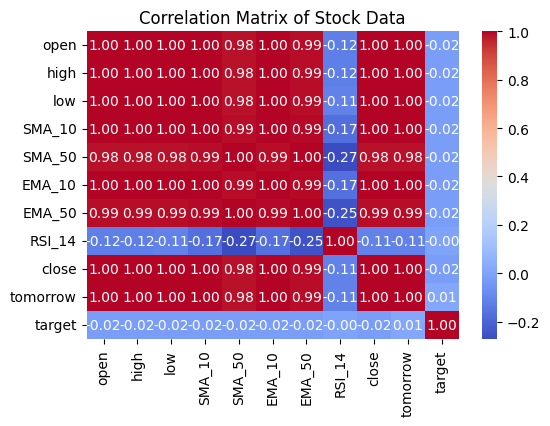

In [18]:
# Plotting the correlation matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Data')
plt.show()

In [19]:
del stock_data_filtered["RSI_14"]
del stock_data_filtered["target"]

stock_data_filtered

,open,high,low,SMA_10,SMA_50,EMA_10,EMA_50,close,tomorrow
Date,,,,,,,,,
2019-03-14,44.149019,44.197036,43.827325,42.529268,39.632640,42.745322,40.479820,44.108208,44.681980
2019-03-15,44.377093,44.972467,44.110614,42.796947,39.771278,43.097442,40.644611,44.681980,45.138130
2019-03-18,44.605173,45.226955,44.602769,43.089115,39.994243,43.468476,40.820827,45.138130,44.780403
2019-03-19,45.217334,45.370979,44.633960,43.353191,40.181033,43.707008,40.976105,44.780403,45.171730
2019-03-20,44.708391,45.491025,44.348285,43.680648,40.377227,43.973321,41.140639,45.171730,46.835423
...,...,...,...,...,...,...,...,...,...
2024-09-24,228.649994,229.350006,225.729996,223.264000,222.119416,224.487162,220.495661,227.369995,226.369995
2024-09-25,224.929993,227.289993,224.020004,223.634999,221.955845,224.829495,220.726027,226.369995,227.520004
2024-09-26,227.300003,228.500000,225.410004,224.109999,221.933938,225.318679,220.992457,227.520004,227.789993


In [20]:
# Separate the last row (used for prediction)
last_row = stock_data_filtered.iloc[-1:]

# Remove the last row from the dataframe
stock_data_filtered = stock_data_filtered.iloc[:-1]

stock_data_filtered

,open,high,low,SMA_10,SMA_50,EMA_10,EMA_50,close,tomorrow
Date,,,,,,,,,
2019-03-14,44.149019,44.197036,43.827325,42.529268,39.632640,42.745322,40.479820,44.108208,44.681980
2019-03-15,44.377093,44.972467,44.110614,42.796947,39.771278,43.097442,40.644611,44.681980,45.138130
2019-03-18,44.605173,45.226955,44.602769,43.089115,39.994243,43.468476,40.820827,45.138130,44.780403
2019-03-19,45.217334,45.370979,44.633960,43.353191,40.181033,43.707008,40.976105,44.780403,45.171730
2019-03-20,44.708391,45.491025,44.348285,43.680648,40.377227,43.973321,41.140639,45.171730,46.835423
...,...,...,...,...,...,...,...,...,...
2024-09-23,227.339996,229.449997,225.809998,222.538000,222.254596,223.846533,220.215076,226.470001,227.369995
2024-09-24,228.649994,229.350006,225.729996,223.264000,222.119416,224.487162,220.495661,227.369995,226.369995
2024-09-25,224.929993,227.289993,224.020004,223.634999,221.955845,224.829495,220.726027,226.369995,227.520004


In [21]:
last_row

,open,high,low,SMA_10,SMA_50,EMA_10,EMA_50,close,tomorrow
Date,,,,,,,,,
2024-09-30,230.039993,233.0,229.649994,226.306998,222.190308,227.082916,221.719458,233.0,NaN


In [22]:
# format using minmaxscalar 
#-------------------------------------

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Create the scaler instance
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the entire dataset, including the 'tomorrow' column
stock_data_scaled = scaler.fit_transform(stock_data_filtered)

# Convert the scaled data back to a DataFrame
stock_data_scaled_df = pd.DataFrame(stock_data_scaled, columns=stock_data_filtered.columns, index=stock_data_filtered.index)

# Rounding min and max values to a reasonable precision
min_value = np.round(stock_data_scaled.min(), 5)
max_value = np.round(stock_data_scaled.max(), 5)

# Check the min and max values for the entire scaled data
print("Scaled Data - Min:", min_value)
print("Scaled Data - Max:", max_value)



Scaled Data - Min: 0.0
Scaled Data - Max: 1.0


In [23]:
stock_data_scaled

array([[9.63662057e-03, 6.79698008e-03, 1.45633241e-02, ...,
        0.00000000e+00, 1.21571890e-02, 1.51334337e-02],
       [1.08127037e-02, 1.07924443e-02, 1.60404309e-02, ...,
        9.11557238e-04, 1.51334337e-02, 1.74995532e-02],
       [1.19888185e-02, 1.21037110e-02, 1.86065974e-02, ...,
        1.88631788e-03, 1.74995532e-02, 1.56439687e-02],
       ...,
       [9.41851115e-01, 9.50196608e-01, 9.54112919e-01, ...,
        9.97051649e-01, 9.57576735e-01, 9.63542007e-01],
       [9.54072302e-01, 9.56431254e-01, 9.61360568e-01, ...,
        9.98525439e-01, 9.63542007e-01, 9.64942481e-01],
       [9.60053972e-01, 9.61686900e-01, 9.71215287e-01, ...,
        1.00000000e+00, 9.64942481e-01, 9.91967577e-01]])

In [24]:
# Preparing the data to train the LSTM model
# --------------------------------------------------------

# Initialize an empty list to store our input sequences
input_sequences = []

# Number of days to look back in the past to make predictions
look_back_days = 90 

# These columns include open, high, low, SMA_10, SMA_50, EMA_10, EMA_50, close
for feature_index in range(8):  # 8 features (excluding 'tomorrow')
    input_sequences.append([])  # Create a new sublist for each feature
    
    # Loop over each day in the dataset, starting from the 90th day
    for current_day in range(look_back_days, stock_data_scaled.shape[0]):
        # For each day, take the last 90 days of data for that feature and add it to input_sequences
        input_sequences[feature_index].append(stock_data_scaled[current_day-look_back_days:current_day, feature_index])

# Convert list to a numpy array
input_sequences = np.array(input_sequences)

# Reshape to be (samples, time_steps, features) for LSTM
x_feature_reshape = np.moveaxis(input_sequences, [0], [2])

# Prepare the target variable ('tomorrow')
y_target_reshape = np.array(stock_data_scaled[look_back_days:, -1])  # Target column is 'tomorrow'

# Reshape y_target to be a 2D array (required for LSTM)
y_target_reshaped = np.reshape(y_target_reshape, (len(y_target_reshape), 1))

print("training feature reshape")
print("---------------------------------------")
print(x_feature_reshape)
print(x_feature_reshape.shape)

print("target feature reshape")
print("---------------------------------------")
print(y_target_reshape)
print(y_target_reshape.shape)

training feature reshape
---------------------------------------
[[[9.63662057e-03 6.79698008e-03 1.45633241e-02 ... 0.00000000e+00
   0.00000000e+00 1.21571890e-02]
  [1.08127037e-02 1.07924443e-02 1.60404309e-02 ... 1.90084154e-03
   9.11557238e-04 1.51334337e-02]
  [1.19888185e-02 1.21037110e-02 1.86065974e-02 ... 3.90378957e-03
   1.88631788e-03 1.74995532e-02]
  ...
  [3.54919894e-02 3.47192477e-02 4.20075904e-02 ... 3.37565340e-02
   3.80154774e-02 4.04525967e-02]
  [3.77163870e-02 3.54890686e-02 4.03237182e-02 ... 3.35844977e-02
   3.83345784e-02 3.66147883e-02]
  [3.50570001e-02 3.63955617e-02 4.18944709e-02 ... 3.45389192e-02
   3.88832147e-02 4.24026859e-02]]

 [[1.08127037e-02 1.07924443e-02 1.60404309e-02 ... 1.90084154e-03
   9.11557238e-04 1.51334337e-02]
  [1.19888185e-02 1.21037110e-02 1.86065974e-02 ... 3.90378957e-03
   1.88631788e-03 1.74995532e-02]
  [1.51454868e-02 1.28458032e-02 1.87692282e-02 ... 5.19145396e-03
   2.74525236e-03 1.56439687e-02]
  ...
  [3.7716387

In [25]:
# Splitting into train and test sets
# --------------------------------------------------------

# Now, split the data into training and testing sets

# Define the split limit at 80% of the dataset length
split_limit = int(len(x_feature_reshape) * 0.8)

# Split the input sequences into training and testing sets
X_train, X_test = x_feature_reshape[:split_limit], x_feature_reshape[split_limit:]

# Split the target values into training and testing sets
y_train, y_test = y_target_reshaped[:split_limit], y_target_reshaped[split_limit:]

# Print the shapes of the training and testing sets to ensure the split was successful
print("X_train shape:", X_train.shape)  # Shape of the training set inputs
print("X_test shape:", X_test.shape)    # Shape of the testing set inputs
print("y_train shape:", y_train.shape)  # Shape of the training set targets
print("y_test shape:", y_test.shape)    # Shape of the testing set targets

# Output the training targets to verify the split
print("Training targets:", y_train)

X_train shape: (1044, 90, 8)
X_test shape: (262, 90, 8)
y_train shape: (1044, 1)
y_test shape: (262, 1)
Training targets: [[0.04421527]
 [0.04215269]
 [0.04305268]
 ...
 [0.69320035]
 [0.68241439]
 [0.69031036]]


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test)
)

Epoch 1/50
33/33 [==============================] - 10s 123ms/step - loss: 0.0151 - val_loss: 0.0119
Epoch 2/50
33/33 [==============================] - 2s 69ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 3/50
33/33 [==============================] - 2s 64ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 4/50
33/33 [==============================] - 2s 62ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 5/50
33/33 [==============================] - 2s 66ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 6/50
33/33 [==============================] - 2s 65ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 7/50
33/33 [==============================] - 2s 64ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 8/50
33/33 [==============================] - 2s 63ms/step - loss: 9.6255e-04 - val_loss: 0.0029
Epoch 9/50
33/33 [==============================] - 2s 63ms/step - loss: 9.3713e-04 - val_loss: 0.0016
Epoch 10/50
33/33 [==============================] - 2s 66ms/step - loss: 9.0532e-04 - val_loss: 0.

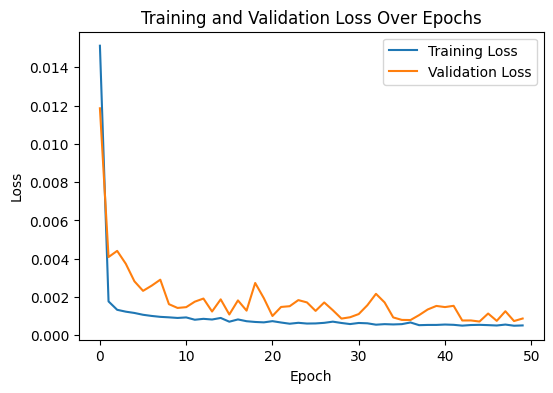

In [27]:
import matplotlib.pyplot as plt

# Extract loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a new figure
plt.figure(figsize=(6, 4))

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()


9/9 [==============================] - 1s 21ms/step
Mean Squared Error (MSE): 0.0008323360722446007
Mean Absolute Error (MAE): 0.022536617697586463
R-squared (R²): 0.9194529388101813


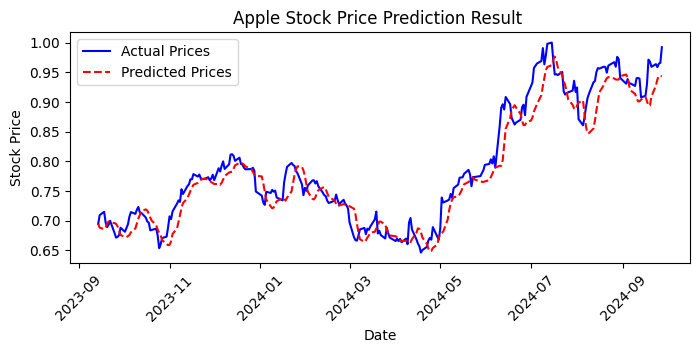

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Predict on the test data
y_pred_scaled = model.predict(X_test)

# Reshape y_pred_scaled to match the shape of y_test for evaluation
y_pred_scaled = np.reshape(y_pred_scaled, (len(y_pred_scaled),))

# Assuming 'y_target' was scaled similarly to the features (e.g., MinMaxScaler):
# Create a reverse scaler for the target variable
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(y_target_reshaped.reshape(-1, 1))

# Inverse transform predictions and actual test targets
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

# visualize the predictions vs actual values
# Assuming you have the test date indices saved
test_dates = stock_data_filtered.index[-len(y_test_actual):]  # Get the corresponding test dates
# Create a figure for plotting
plt.figure(figsize=(8, 3))
# Plot the actual stock prices using the saved test dates as the x-axis
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='blue')
# Plot the predicted stock prices using the same test dates as the x-axis
plt.plot(test_dates, y_pred, label='Predicted Prices', color='red', linestyle='--')  # Dashed line for predictions
# Set plot title and labels
plt.title('Apple Stock Price Prediction Result ')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [29]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            11800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32,051
Trainable params: 32,051
Non-trainable params: 0
_________________________________________________________________


In [30]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Assuming 'y_target_reshaped' is the target data used for scaling
# Fit the scaler on the original target data
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(stock_data_filtered[['tomorrow']].values)  # Fit scaler on the original 'tomorrow' values

# Extract the test data indices
test_indices = stock_data_filtered.index[-len(X_test):]

# Create a DataFrame for the test data
test_df = stock_data_filtered.loc[test_indices].copy()

# Predict on the test data
y_pred_scaled = model.predict(X_test)

# Reshape y_pred_scaled to match the shape of y_test for evaluation
y_pred_scaled = np.reshape(y_pred_scaled, (len(y_pred_scaled),))

# Inverse transform predictions to get them back to the original scale
# Use the scaler fitted on the original 'tomorrow' values
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Add the predictions as a new column to the DataFrame
test_df['Predicted'] = y_pred

# Print the first few rows to verify
test_df


9/9 [==============================] - 0s 20ms/step


,open,high,low,SMA_10,SMA_50,EMA_10,EMA_50,close,tomorrow,Predicted
Date,,,,,,,,,,
2023-09-14,173.114159,175.203474,172.696299,180.206862,183.981096,177.938214,180.921194,174.845306,174.119003,174.128006
2023-09-15,175.581521,175.601423,172.935074,178.927408,183.651954,177.243812,180.654442,174.119003,177.063950,172.890900
2023-09-18,175.581530,178.466775,175.273110,177.784256,183.404165,177.211110,180.513638,177.063950,178.158340,172.367920
2023-09-19,176.616229,178.715487,176.228215,176.726668,183.219398,177.383334,180.421273,178.158340,174.596588,172.991119
2023-09-20,178.347384,178.785147,174.507035,175.988446,182.973927,176.876653,180.192854,174.596588,173.044510,174.169022
...,...,...,...,...,...,...,...,...,...,...
2024-09-23,227.339996,229.449997,225.809998,222.538000,222.254596,223.846533,220.215076,226.470001,227.369995,220.209030
2024-09-24,228.649994,229.350006,225.729996,223.264000,222.119416,224.487162,220.495661,227.369995,226.369995,222.251434
2024-09-25,224.929993,227.289993,224.020004,223.634999,221.955845,224.829495,220.726027,226.369995,227.520004,223.495209


In [31]:
stock_data_filtered

,open,high,low,SMA_10,SMA_50,EMA_10,EMA_50,close,tomorrow
Date,,,,,,,,,
2019-03-14,44.149019,44.197036,43.827325,42.529268,39.632640,42.745322,40.479820,44.108208,44.681980
2019-03-15,44.377093,44.972467,44.110614,42.796947,39.771278,43.097442,40.644611,44.681980,45.138130
2019-03-18,44.605173,45.226955,44.602769,43.089115,39.994243,43.468476,40.820827,45.138130,44.780403
2019-03-19,45.217334,45.370979,44.633960,43.353191,40.181033,43.707008,40.976105,44.780403,45.171730
2019-03-20,44.708391,45.491025,44.348285,43.680648,40.377227,43.973321,41.140639,45.171730,46.835423
...,...,...,...,...,...,...,...,...,...
2024-09-23,227.339996,229.449997,225.809998,222.538000,222.254596,223.846533,220.215076,226.470001,227.369995
2024-09-24,228.649994,229.350006,225.729996,223.264000,222.119416,224.487162,220.495661,227.369995,226.369995
2024-09-25,224.929993,227.289993,224.020004,223.634999,221.955845,224.829495,220.726027,226.369995,227.520004


In [32]:
last_row

,open,high,low,SMA_10,SMA_50,EMA_10,EMA_50,close,tomorrow
Date,,,,,,,,,
2024-09-30,230.039993,233.0,229.649994,226.306998,222.190308,227.082916,221.719458,233.0,NaN


In [33]:
# making new prediction on the last row 
# ----------------------------------------- 

# Ensure the feature scaler is fitted on the original training data
# Feature scaler for the data used for training
feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(stock_data_filtered[['open', 'high', 'low', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'close']])

# Transform the last_row data
last_row_scaled = feature_scaler.transform(last_row[['open', 'high', 'low', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'close']])

# Prepare the data for prediction
# As we need a sequence of look_back_days, repeat the last_row_scaled to form the sequence
look_back_days = 90  # Same look_back_days used in training
input_sequence = np.array([last_row_scaled] * look_back_days)

# Reshape to be (samples, time_steps, features)
input_sequence = np.reshape(input_sequence, (1, look_back_days, last_row_scaled.shape[1]))

# Predict the 'tomorrow' value
predicted_scaled = model.predict(input_sequence)

# Reshape prediction to match the scaler input shape
predicted_scaled = np.reshape(predicted_scaled, (1,))

# Create a target scaler fitted on the 'tomorrow' column of stock_data_filtered
# Fit the scaler on non-NaN values of 'tomorrow'
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(stock_data_filtered[['tomorrow']].dropna().values.reshape(-1, 1))

# Inverse transform the prediction
predicted = target_scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

# Print the predicted value
print(f"Predicted 'tomorrow' value for {last_row.index[0]}: {predicted[0][0]}")

1/1 [==============================] - 0s 35ms/step
Predicted 'tomorrow' value for 2024-09-30 00:00:00: 225.98191833496094


In [34]:
# Assuming your DataFrame is named stock_data_filtered
row = stock_data_filtered.loc['2024-08-15']
print(row)

open        224.600006
high        225.350006
low         222.759995
SMA_10      215.949509
SMA_50      216.791959
EMA_10      218.743117
EMA_50      213.553680
close       224.720001
tomorrow    226.050003
Name: 2024-08-15 00:00:00, dtype: float64


In [35]:
# Save the trained LSTM model to an HDF5 file
model.save('apple_stock_lstm_model.h5')

print("Model saved successfully!")


Model saved successfully!
